## **Notebook PC#01**
## Regularized Linear Classifier for the MNIST database. Designed from scratch.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** <br>
**Aluno(a):**


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.datasets import mnist

(Xp, y), (Xtp, yt) = mnist.load_data()
Xa = Xp.reshape(Xp.shape[0], 784)
Xta = Xtp.reshape(Xtp.shape[0], 784)

Xa = Xa / 255.0
Xta = Xta / 255.0

X0 = np.ones((Xp.shape[0],1))
X = np.hstack((X0,Xa))
Xt0 = np.ones((Xtp.shape[0],1))
Xt = np.hstack((Xt0,Xta))

print("Shape of X: ".ljust(10),  X.shape)
print("Shape of y: ".ljust(10),  y.shape)
print("Shape of Xt: ".ljust(10),  X.shape)
print("Shape of yt: ".ljust(10),  yt.shape)

2024-03-31 16:21:09.157522: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Shape of X:  (60000, 785)
Shape of y:  (60000,)
Shape of Xt:  (60000, 785)
Shape of yt:  (10000,)


In [2]:
# Visualizing a random data point
import plotly.express as px

ind = np.random.randint(60000)
print('Data point: ', ind, '\n', 'Label: ', y[ind])
fig = px.imshow(255-Xp[ind], binary_string=True, width=200, height=200)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(margin=dict(l=1, r=1, t=1, b=1))
fig.show()

Data point:  59496 
 Label:  9


In [3]:
# Dataset balancing analysis
from tensorflow.keras.utils import to_categorical

yy = to_categorical(y)
yyt = to_categorical(yt)
sum_along_columns1 = np.sum(yy, axis = 0)
print(sum_along_columns1)
sum_along_columns2 = np.sum(yyt, axis = 0)
print(sum_along_columns2)
fig1 = px.bar(x=range(10),y=sum_along_columns1, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the training dataset</b>")
fig1.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig1.show()
fig2 = px.bar(x=range(10),y=sum_along_columns2, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the test dataset</b>")
fig2.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig2.show()

[5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
[ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]


In [4]:
partition = 0.7

# Mixing the dataset before partitioning
index = np.arange(0,X.shape[0])
np.random.shuffle(index)

training_set_size = int(X.shape[0] * partition)

index_training = index[:training_set_size]
index_validation = index[training_set_size:]


X_training = X[index_training]
y_training = yy[index_training]

X_validation = X[index_validation]
y_validation = yy[index_validation]

print("X_training:".ljust(20), X_training.shape)
print("y_training:".ljust(20), y_training.shape)

print("X_validation:".ljust(20), X_validation.shape)
print("y_validation:".ljust(20), y_validation.shape)

X_training:          (42000, 785)
y_training:          (42000, 10)
X_validation:        (18000, 785)
y_validation:        (18000, 10)


In [5]:
def get_class_from_sample(sample: np.ndarray):
    class_ = 1
    for i in sample:
        if i == 0:
            class_ += 1
        else:
            break
    return class_

In [6]:
def get_w(X, y, c):
    w_1 = (np.matmul(np.transpose(X), X) + c * np.eye(X.shape[1]))
    w_2 = np.matmul(np.transpose(X), y)
    w,resid,rank,s = np.linalg.lstsq(w_1, w_2, rcond=None)
    return w


In [7]:
def get_rates_from_c_values(X, y, c_values, Ws = []):
    hit_rates = []

    if len(Ws) != 0:
        are_Ws_given = True
    else:
        are_Ws_given = False
        Ws = []

    for index, c in enumerate(c_values):
        print(c)

        if are_Ws_given:
            W = Ws[index]
        else:
            W = get_w(X, y, c)
            Ws.append(W)

        y_estimate = np.matmul(X,W)
        hits = 0
        for index, estimate in enumerate(y_estimate):
            max_index = np.where(estimate == np.amax(estimate))[0][0]
            estimated_class = max_index + 1
            if estimated_class == get_class_from_sample(y[index]):
                hits += 1
        hit_rates.append(hits/y_estimate.shape[0])
    return hit_rates, Ws

In [8]:
c_values = [pow(2,d) for d in range(-10, 19, 2)] # Range goes up to 19 to ensure search up to 2^18

hit_rates_training, Ws = get_rates_from_c_values(X_training, y_training, c_values)

0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536
262144


In [9]:
hit_rates_validation, _ = get_rates_from_c_values(X_validation, y_validation, c_values, Ws)

0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536
262144


Best c value: 256 
Performance of this value: 0.8558888888888889


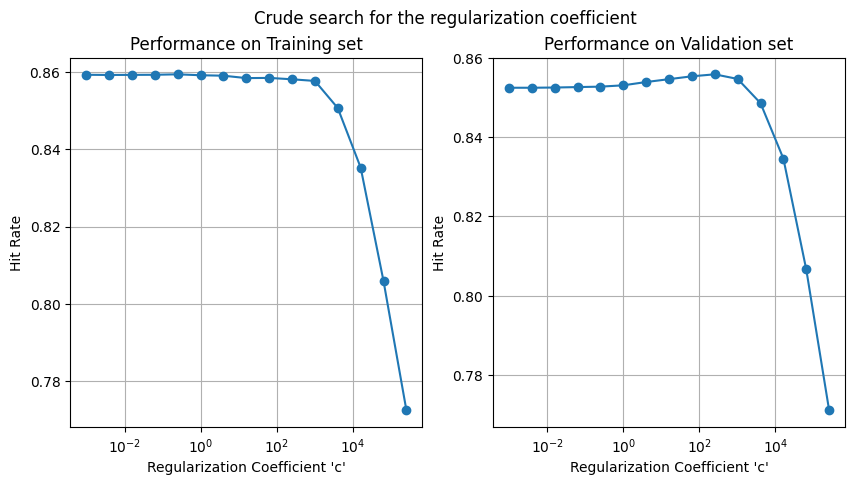

In [10]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation[best_c_index]))



<font color="green">
Atividade (a) <br>
Confira se o intervalo de excursão da busca está adequado. Justifique sua resposta. <br>
Caso não esteja, faça modificações pertinentes até encontrar um bom intervalo de busca. <br>
</font>

Resposta:

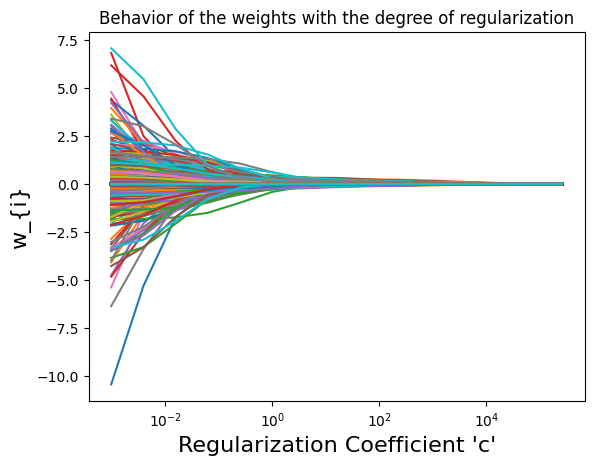

In [11]:
lambd_values = c_values
w_values = Ws
import numpy as np
import matplotlib.pyplot as plt

def plot_regularization_path(lambd_values, w_values):
    num_coeffs = len(w_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in w_values])
    plt.xlabel(r"Regularization Coefficient 'c'", fontsize=16)
    plt.ylabel(r"w_{i}", fontsize=16)
    plt.xscale("log")
    plt.title("Behavior of the weights with the degree of regularization")
    plt.show()

plot_regularization_path(lambd_values, w_values)

In [12]:
step =  0.1 * (4 * best_c - best_c / 4);

fine_c_values = np.arange((best_c/4), (4*best_c) + step / 10, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(X_training, y_training, fine_c_values)

64.0
160.0
256.0
352.0
448.0
544.0
640.0
736.0
832.0
928.0
1024.0


In [13]:
hit_rates_validation_fine, _ = get_rates_from_c_values(X_validation, y_validation, fine_c_values, Ws_fine)

64.0
160.0
256.0
352.0
448.0
544.0
640.0
736.0
832.0
928.0
1024.0


Best c value: 160.0 
Performance of this value: 0.8560555555555556


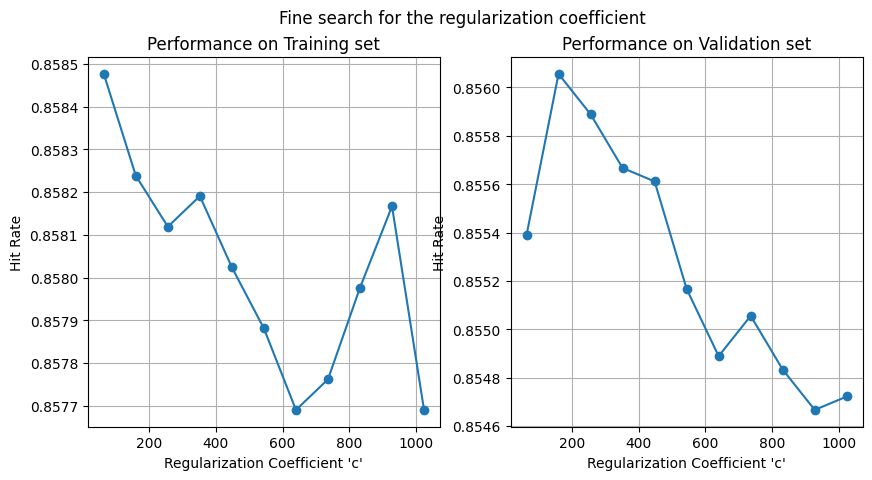

In [14]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [15]:
W = get_w(X, yy, best_c)
print(W.shape)

(785, 10)


In [16]:
yt_estimate = np.matmul(Xt,W)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df

Performance on test set: 0.8622


,0,1,2,3,4,5,6,7,8,9
0,944,0,18,4,0,23,17,4,14,16
1,0,1106,57,17,21,18,10,45,49,11
2,1,2,821,21,6,4,9,15,11,2
3,2,2,24,887,0,78,0,6,32,17
4,2,3,16,6,885,23,20,24,25,77
5,7,1,0,15,3,650,17,0,38,0
6,14,5,35,10,9,25,879,1,17,1
7,2,1,17,22,1,15,0,888,14,76
8,7,15,39,18,10,39,6,0,757,4
9,1,0,5,10,47,17,0,45,17,805


In [17]:
def f_score(confusion_matrix, betas):
    recall = confusion_matrix[range(10), range(10)]/np.sum(confusion_matrix, axis=0)
    precision = confusion_matrix[range(10), range(10)]/np.sum(confusion_matrix, axis=1)

    f_scores = np.zeros((len(betas), 10))

    for i, b in enumerate(betas):
        f_scores[i] = (1 + b**2) * precision * recall/(b**2 * precision + recall)

    return f_scores

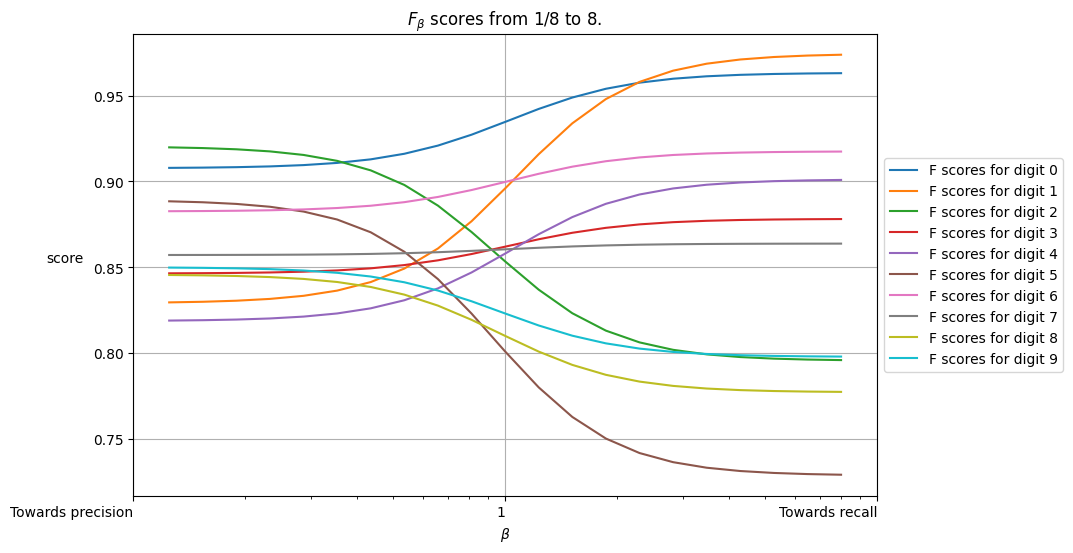

In [18]:
fig, ax = plt.subplots(figsize=(12,6))

for i in range(10):
    plt.plot(np.logspace(-3, 3, base=2, num=21), f_score(confusion_matrix, np.logspace(-4, 4, base=2, num=21))[:, i], label=f"F scores for digit {i}")

ax.set_xlabel("$\\beta$")
ax.set_ylabel("score", rotation=0, labelpad=20)

ax.set_xscale('log')
ax.set_xticks(np.geomspace(10**-1, 10**1 ,3), ["Towards precision", "1","Towards recall"], ha='right')
ax.grid()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.get_xaxis

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title("$F_{\\beta}$ scores from 1/8 to 8.")

plt.show()

<font color="green">
Atividade (b) <br>
Indique quais são as duas classes mais desafiadoras para o classificador e qual o critério usado por você para chegar a esta conclusão. <br>
</font>

Resposta:

#### **Visualization of the 10 vectors of weights W, without the bias.**



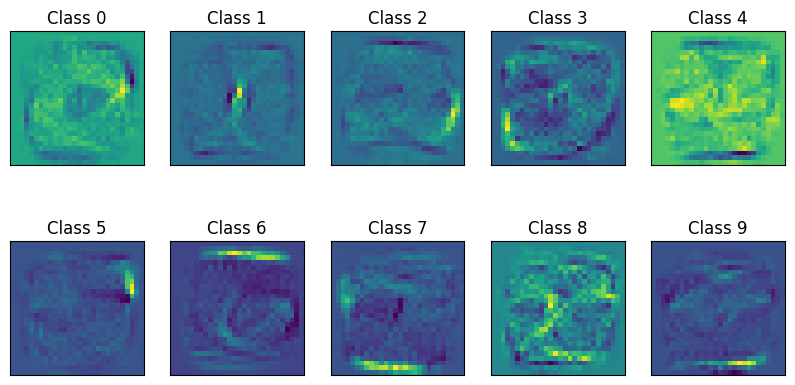

In [19]:
# Only for the MNIST dataset
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = W[1:,i].reshape([28,28])
    plt.title(f'Class {i}')
    plt.imshow(weight, cmap='viridis')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

#### **To improve the visualization of the 10 vectors of weights W, the use of a divergent color map is indicated: the average value of the color map is a neutral color and the extreme values represent different colors. Using a divergent color map and a bilinear interpolation scheme (to facilitate the visualization of low-resolution images), the result of the visualization of the 10 vectors of weights W is illustrated in the following images.**

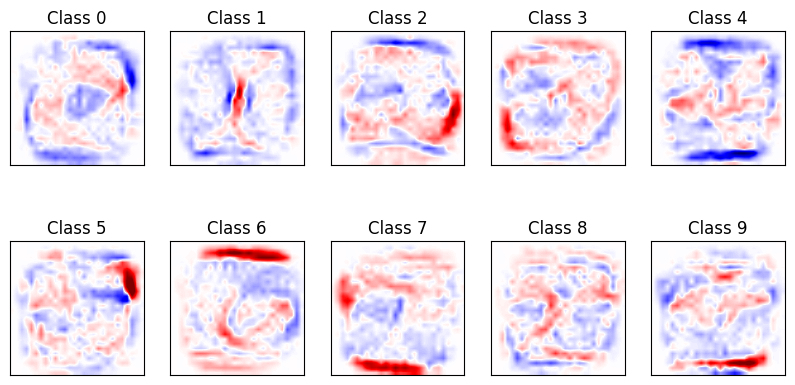

In [20]:
# Only for the MNIST dataset
scale = np.abs(W).max()
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = W[1:,i].reshape([28,28])
    plt.title(f'Class {i}')
    plt.imshow(weight, cmap=plt.cm.seismic, vmin=-scale/2, vmax=scale/2, interpolation='bilinear')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

<font color="green">
Atividade (c) <br>
Com base nesses dois resultados visuais acima, responda: Qual é a estratégia adotada pelo classificador linear para buscar máximo desempenho? <br>
</font>

Resposta:

#### **Performance of the average 10 vectors of weights (here no bias is considered)**

In [21]:
W1 = np.zeros((784, 10))
for i in range(10):
  aux = np.mean(Xp[y==i], axis=0)
  aux = aux.reshape(784)/255
  aux = aux-np.mean(aux)
  W1[:,i] = aux/np.sqrt(np.sum(np.square(aux)))
yt_estimate = np.matmul(Xta,W1)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df

Performance on test set: 0.8208


,0,1,2,3,4,5,6,7,8,9
0,902,0,27,6,4,27,29,8,7,16
1,0,1074,51,5,10,37,14,51,21,17
2,6,9,776,25,3,9,16,26,11,6
3,3,4,43,851,0,137,1,0,91,12
4,0,0,27,1,793,20,18,16,12,80
5,33,4,0,28,1,564,22,0,29,11
6,25,4,31,8,24,29,850,1,17,3
7,1,0,15,14,1,11,0,849,10,29
8,10,40,56,52,19,34,8,22,738,24
9,0,0,6,20,127,24,0,55,38,811


#### **Visualization of the average 10 vectors of weights**

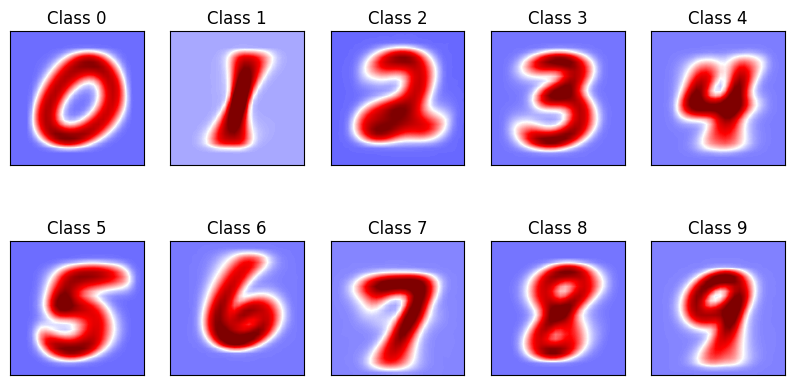

In [22]:
# Only for the MNIST dataset
scale = np.abs(W1).max()
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = W1[:,i].reshape([28,28])
    plt.title(f'Class {i}')
    plt.imshow(weight, cmap=plt.cm.seismic, vmin=-scale/2, vmax=scale/2, interpolation='bilinear')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

<font color="green">
Atividade (d) <br>
Com base na execução das duas células acima, responda: Por que motivo os vetores com a média das imagens por classe não levam a um classificador de máximo desempenho? Nota: A resposta não depende do fato do classificador aqui não adotar o bias em sua implementação. <br>
</font>

Resposta:

Image no. 11


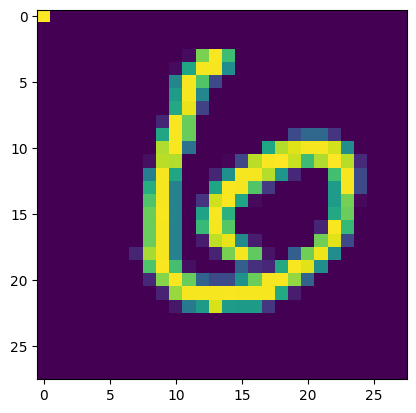

Real: 6
Predicted: 4
Rank of the correct answer: 8
Probabilities: [ 0.24155222  0.16484893  0.1730051   0.07443729  0.29338817 -0.19930476
  0.05614975 -0.05821814  0.1795415   0.06359971] 

Image no. 33


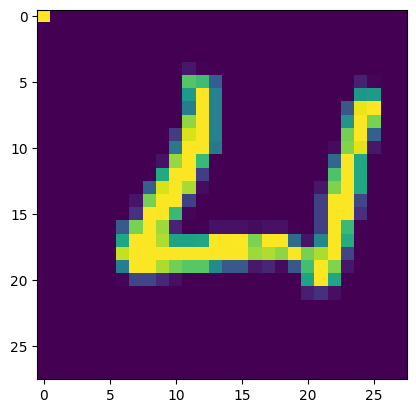

Real: 4
Predicted: 5
Rank of the correct answer: 4
Probabilities: [ 0.36214252 -0.07275415  0.1864798  -0.31730712  0.21372338  0.37147442
  0.21996803 -0.02136809  0.07044379 -0.03137944] 

Image no. 38


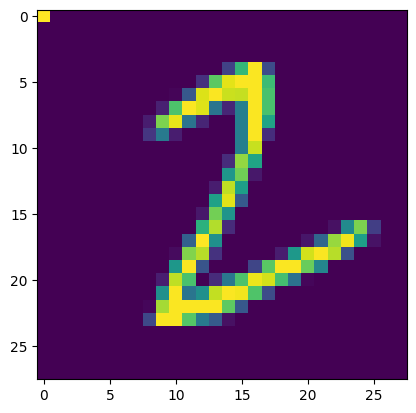

Real: 2
Predicted: 1
Rank of the correct answer: 5
Probabilities: [ 0.19215308  0.35135129  0.15990304  0.2555557  -0.27345815  0.08600804
  0.19901969 -0.03255162  0.11754613 -0.07342224] 

Image no. 43


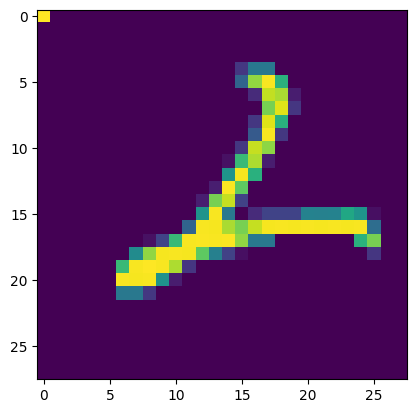

Real: 2
Predicted: 1
Rank of the correct answer: 2
Probabilities: [-0.02634183  0.36104482  0.26028921  0.05947028  0.2211337   0.06616412
 -0.02912915 -0.01739594  0.11798554 -0.03467134] 

Image no. 45


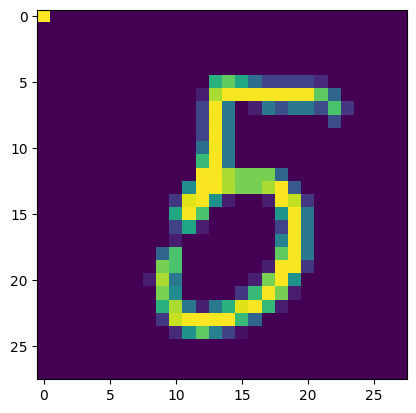

Real: 5
Predicted: 3
Rank of the correct answer: 2
Probabilities: [ 0.088781   -0.11539777 -0.05229209  0.37646573  0.05273595  0.35091848
  0.18033556 -0.07206954  0.17337901  0.00231464] 

Image no. 46


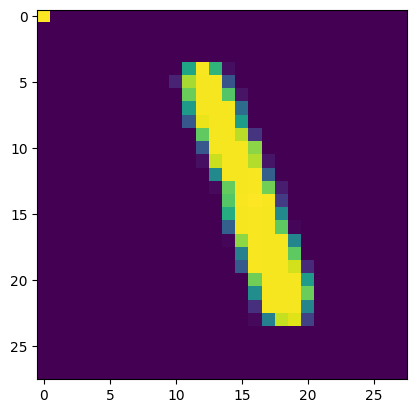

Real: 1
Predicted: 3
Rank of the correct answer: 2
Probabilities: [-2.83738976e-01  3.18734168e-01  1.46716018e-01  3.47617696e-01
  9.69184281e-02  1.97981591e-01  6.28273408e-02  4.95187844e-02
  3.10915521e-05  5.92969021e-02] 

Image no. 47


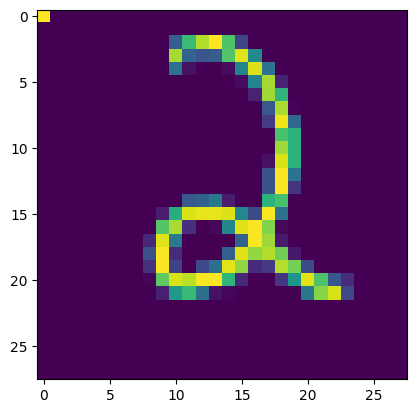

Real: 2
Predicted: 6
Rank of the correct answer: 2
Probabilities: [-0.00078015  0.0029652   0.30710857  0.05052114 -0.0920337   0.11554886
  0.55774528  0.06931105 -0.08082112  0.05807374] 

Image no. 54


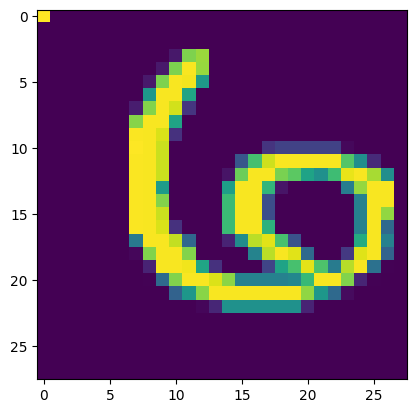

Real: 6
Predicted: 2
Rank of the correct answer: 2
Probabilities: [ 0.09284486  0.14508028  0.48068458 -0.05330107  0.17663907 -0.22369373
  0.45570973 -0.08326353  0.07162178 -0.05854549] 

Image no. 63


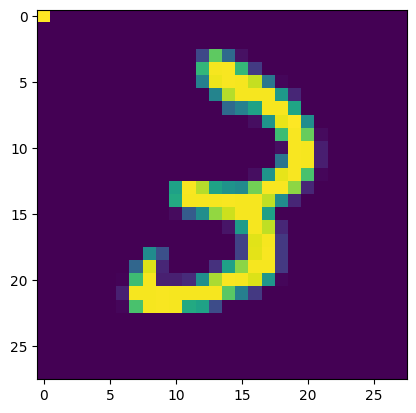

Real: 3
Predicted: 2
Rank of the correct answer: 3
Probabilities: [ 0.06673814  0.04851988  0.41949197  0.18399611  0.0758296  -0.03372164
 -0.06368447 -0.11016281  0.12316296  0.28077987] 

Image no. 66


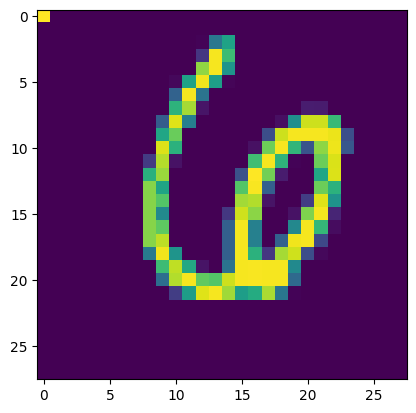

Real: 6
Predicted: 1
Rank of the correct answer: 4
Probabilities: [ 0.23663472  0.28021847  0.11299192  0.13122007  0.21747633 -0.09172411
  0.20858998  0.12893561 -0.0829091  -0.14779502] 

Image no. 80


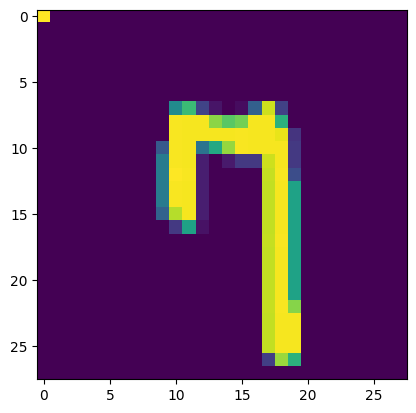

Real: 7
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.09999029 -0.13528339  0.00112506  0.06765158  0.06397428  0.09246666
  0.00755108  0.43798962 -0.20396796  0.56732858] 

Image no. 92


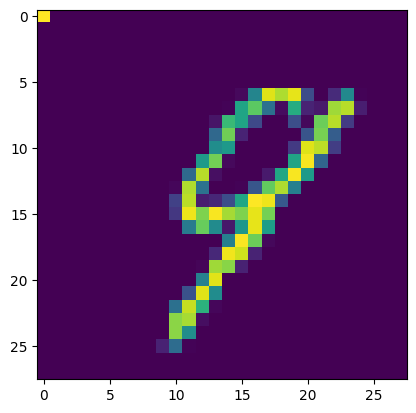

Real: 9
Predicted: 4
Rank of the correct answer: 2
Probabilities: [ 0.03306434  0.12146491  0.09309114 -0.03167987  0.27451665  0.06607122
  0.03816395  0.12470463  0.06611372  0.19416504] 

Image no. 97


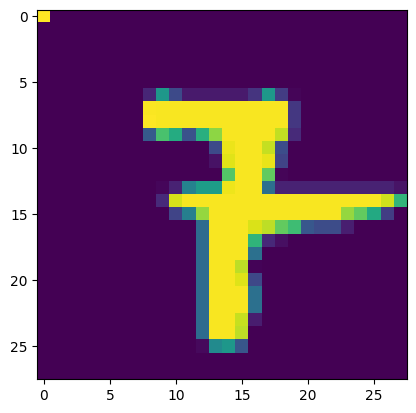

Real: 7
Predicted: 1
Rank of the correct answer: 2
Probabilities: [-0.13796387  0.39415485 -0.12581345  0.20959689  0.1446175   0.00884675
  0.19874622  0.3784538  -0.01873135 -0.03517163] 

Image no. 111


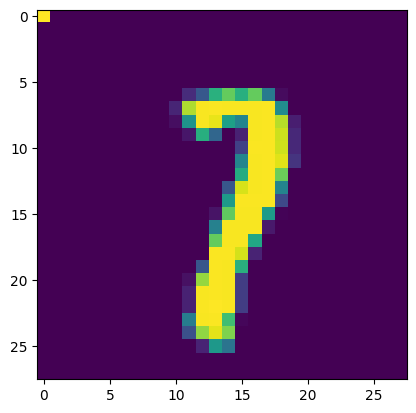

Real: 7
Predicted: 1
Rank of the correct answer: 2
Probabilities: [-0.06397835  0.51465089  0.09379586  0.16035148 -0.08626021 -0.00252439
 -0.03738514  0.22018716  0.02510609  0.17615478] 

Image no. 120


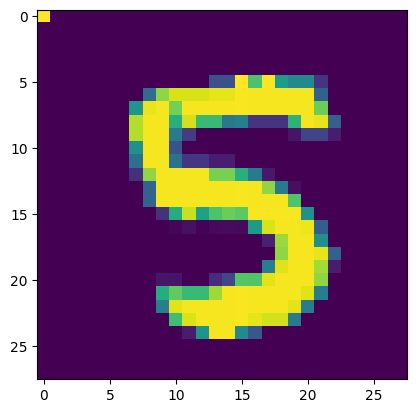

Real: 5
Predicted: 3
Rank of the correct answer: 2
Probabilities: [ 0.07696766 -0.09722011 -0.15323406  0.42564057  0.13196722  0.41578076
  0.17567687 -0.16097949  0.2315382  -0.04023186] 

Image no. 124


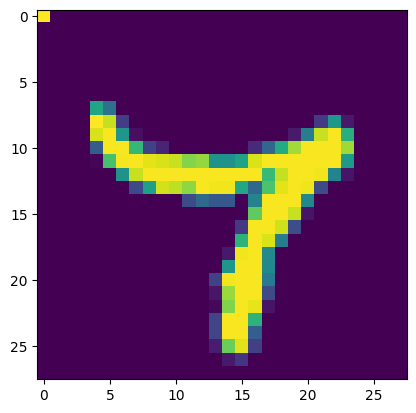

Real: 7
Predicted: 4
Rank of the correct answer: 2
Probabilities: [-0.21734242  0.02257644 -0.24340099  0.17041671  0.40712737 -0.08226787
  0.06141443  0.32801672  0.29172912  0.257959  ] 

Image no. 149


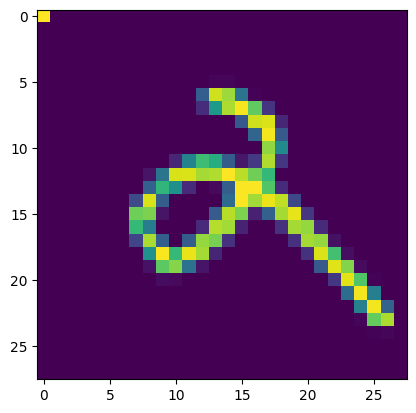

Real: 2
Predicted: 1
Rank of the correct answer: 4
Probabilities: [-0.0152336   0.30588993  0.11534674  0.03619206  0.2269321   0.0656156
  0.04358878 -0.14853911  0.08705003  0.26392484] 

Image no. 150


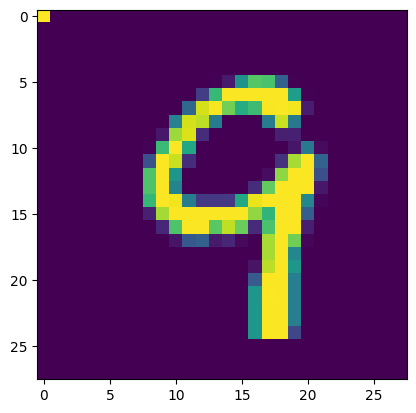

Real: 9
Predicted: 4
Rank of the correct answer: 2
Probabilities: [-0.00327408  0.05753577  0.05131339  0.06726109  0.38991431  0.03472533
  0.05503365 -0.09550937  0.05920941  0.37720292] 

Image no. 151


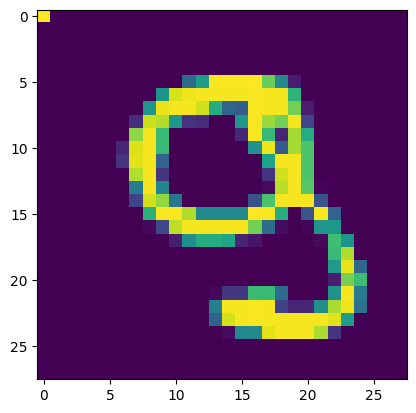

Real: 9
Predicted: 8
Rank of the correct answer: 3
Probabilities: [ 0.17812395  0.03981531  0.10579347  0.03979468  0.27711808 -0.07428577
 -0.18866275  0.09587046  0.32243638  0.20923648] 

Image no. 185


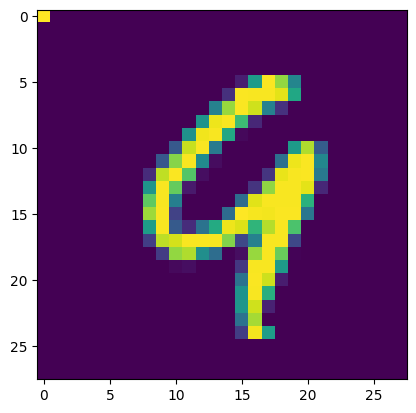

Real: 9
Predicted: 4
Rank of the correct answer: 2
Probabilities: [-0.03810658  0.04174952  0.05268662 -0.08362358  0.39890155 -0.13288375
  0.10483979  0.04561626  0.23725912  0.36595345] 

Image no. 187


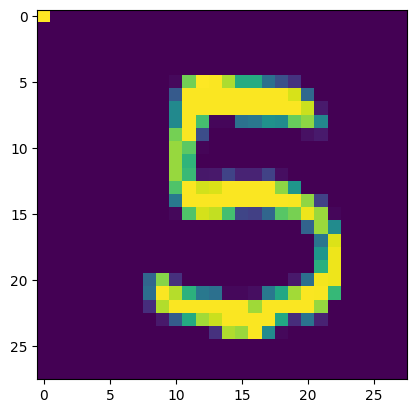

Real: 5
Predicted: 3
Rank of the correct answer: 2
Probabilities: [ 0.11698608 -0.05095649  0.13769744  0.37911121 -0.0541371   0.37515878
 -0.0620907  -0.1918411   0.13187904  0.21028805] 

Image no. 195


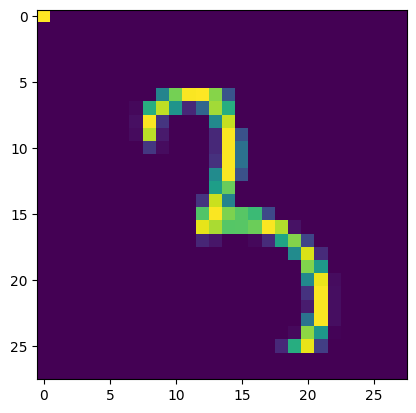

Real: 3
Predicted: 9
Rank of the correct answer: 3
Probabilities: [-0.10744779  0.00542544  0.06622585  0.14036268  0.05745578  0.23069503
  0.09349505  0.1066267   0.1174146   0.25589481] 



In [23]:
def find_pos(item, lst):
    pos = [i for (z, i) in zip(lst, range(len(lst))) if item == z]
    return pos

def display_sample(sample: np.ndarray):

    sample = np.array(sample, dtype='float')
    pixels = np.zeros((28,28))

    for i in range(28):
        for j in range(28):
            pixels[i,j] = sample[i * 28 + j]

    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='viridis')
    plt.show()

yt_estimate = np.matmul(Xt,W)
for i in range(200):
    if yyt[i][np.argmax(yt_estimate[i,:])] != 1:
      print(f"Image no. {i}")
      display_sample(Xt[i])
      print(f"Real: {np.argmax(yyt[i,:])}")
      print(f"Predicted: {np.argmax(yt_estimate[i,:])}")
      value = yt_estimate[i,np.argmax(yyt[i,:])]
      v_sorted = np.sort(yt_estimate[i,:])
      value_index = find_pos(value,v_sorted)
      print(f"Rank of the correct answer: {10 - value_index[0]}")
      print(f"Probabilities: {yt_estimate[i,:]} \n")

<font color="green">
Atividade (e) <br>
Informe o que faz esta última célula executável do notebook e analise os resultados obtidos logo acima. <br>
</font>

Resposta: